## 강아지 사진 배경 교체

**DeepLabV3 (ResNet101)** semantic segmentation 모델을 활용하여:
1. 강아지 사진의 **배경을 마테호른으로 전환**
2. 강아지 사진에 **아웃포커싱 효과** 적용

을 구현합니다. 또한 세그멘테이션 마스크의 오류를 분석하고 개선 솔루션을 제시합니다.

### Step 0: 패키지 설치
- `opencv-python`: 이미지 처리 라이브러리 (블러, 리사이즈, 색상변환등)
- `pixellib`: 세그멘테이션 관련 유틸리티 ( 과제에서 직접 사용하지 않지만 의존성으로 설치)

In [14]:
!pip install opencv-python pixellib


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


### Step 1: 라이브러리 임포트
- `cv2` (OpenCV): 이미지 읽기/쓰기, 블러, 리사이즈등 컴퓨터 비전 처리
- `numpy`: 다차원 배열 연산. 마스크 생성등 연산
- `torch`: PyTorch 딥러닝 프레임워크. 모델 추론
- `torchvision.transforms`: 이미지 전처리 파이프라인 (리사이즈, 텐서 변환, 정규화)
- `deeplabv3_resnet101`: ResNet101 백본 기반 DeepLabV3 세그멘테이션 모델
- `DeepLabV3_ResNet101_Weights`: 사전학습 가중치 enum (deprecated `pretrained=True` 대체)
- `matplotlib.pyplot`: 이미지 시각화

In [15]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


### Step 2: 이미지 로드 및 확인
- `cv2.imread()`: BGR 포맷으로 이미지 읽기
- `cv2.cvtColor(BGR2RGB)`:  RGB 포맷으로 전환
- 원본 강아지 이미지 (4032×3024)와 배경 마테호른 이미지 (1191×795)를 로드합니다

원본 강아지 이미지 크기: (4032, 3024, 3)
배경(마테호른) 이미지 크기: (1191, 795, 3)


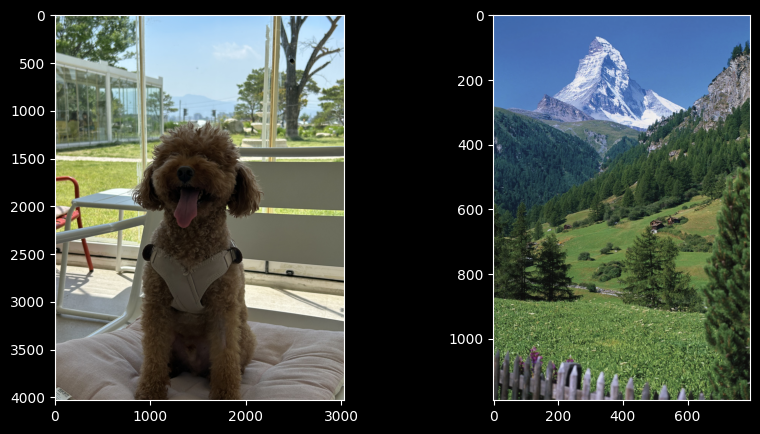

In [16]:
cat_img_path = "dog.jpg"  # 동물 이미지 ->우리 강아지 사진으로 선택
sand_img_path = "matehorn.jpg"  # 배경은 마테호른 선택

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 강아지 이미지 크기: {cat_img.shape}")
print(f"배경(마테호른) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

### Step 3: DeepLabV3 모델 로드 및 세그멘테이션 추론

**핵심 포인트:**
- `weights=DeepLabV3_ResNet101_Weights.DEFAULT`: 최신 사전학습 가중치 사용 (deprecated `pretrained=True` 대체)
- `T.Resize((1024, 1024))`: 원본 4032×3024너무 커서 축소 필요 그런데 520으로 하면 귀가 뭉개짐 그래서 1024로 조정
- `T.Normalize(mean, std)`: **ImageNet 정규화 **. 이 없으면 모델 예측 정확도가 크게 떨어짐
- `model.eval()`: 추론 모드로 전환 (BatchNorm, Dropout 비활성화)
- `torch.no_grad()`: 역전파 불필요
- `output.argmax(0)`: 각 픽셀에서 가장 높은 확률의 클래스 ID 선택 (모델의 출력은 각 픽셀마다 21개 클래스별 확률이 나옵니다)
                       예 class 12 (dog): 0.95 dog 이 가장 높음

In [17]:
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((1024, 1024)),  # 모델 입력 크기 (520→1024 증가)
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet 정규화
])

input_tensor = transform(cat_img).unsqueeze(0)#이미지를 텐서로 만들어서 정규화 /배치,채널,높이,너비

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (1024, 1024)


### Step 4: 마스크 리사이즈 및 클래스 확인
- 모델 출력 마스크 (1024×1024)를 원본 이미지 크기 (4032×3024)로 확대
- `INTER_NEAREST`: 클래스 ID가 정수이므로 보간 없이 최근접 이웃 방식 사용 (값 변형 방지)
- `np.unique()`: 마스크에 어떤 클래스들이 검출되었는지 확인

PASCAL VOC 클래스: 0=background, 6=bus, 7=car, 8=cat, 9=chair, 11=diningtable, **12=dog**, 15=person 등

In [18]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (4032, 3024)


In [19]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0  9 11 12]


### Step 5: Semantic Segmentation Mask 오류 분석 및 솔루션

### 발견된 문제점

DeepLabV3 모델로 생성한 세그멘테이션 마스크에서 다음과 같은 오류가 발견되었습니다:

1. **강아지 얼굴 일부 누락**: 마스크에서 강아지 얼굴 영역이 깨져서 배경으로 잘못 분류됨
2. **오분류**: 정규화 미적용 시 예측 클래스 ID가 `[0, 9, 11, 12]`로, 강아지(12) 외에 chair(9), dining table(11) 등 관련 없는 클래스가 검출됨
3. **거친 경계선**: 520×520 저해상도 마스크를 4032×3024로 확대하면서 경계가 톱니바퀴처럼 울퉁불퉁해짐
4. **바이너리 합성의 부자연스러움**: 0/255 이진 마스크로 합성하면 전경/배경 경계가 뚝 잘려 부자연스러움

### 솔루션 및 이유

**솔루션 1: ImageNet 정규화 적용 (가장 중요)**
- `T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` 추가
- **이유**: DeepLabV3는 ImageNet 데이터셋으로 사전학습된 모델. 학습 시 사용된 것과 동일한 정규화를 적용해야 모델이 올바른 입력 분포를 받아 정확한 예측 가능. 정규화 없이는 픽셀 값 분포가 달라져 오분류 빈도가 급격히 증가

**솔루션 2: 입력 해상도 증가 (520→1024)**
- `T.Resize((1024, 1024))` 로 변경
- **이유**: 원본 4032×3024를 520×520으로 축소하면 약 7.7배 축소. 귀, 코, 입 등 세밀한 부위의 디테일이 손실되어 정확한 경계 인식 불가. 해상도를 높이면 더 세밀한 세그멘테이션 가능

**솔루션 3: Morphological 후처리 (마스크 정제)**
- `cv2.morphologyEx(MORPH_CLOSE)` + `cv2.morphologyEx(MORPH_OPEN)` 적용
- **이유**: CLOSE 연산(팽창→침식)은 마스크 내부의 작은 구멍을 메워줌. OPEN 연산(침식→팽창)은 외부 노이즈 제거. 세그멘테이션 마스크의 완성도 향상

**솔루션 4: 알파 블렌딩으로 자연스러운 합성**
- 마스크 경계에 가우시안 블러 적용 후 알파값으로 그라데이션 합성
- **이유**: 바이너리 마스크(0 or 255)로 `np.where` 합성 시 경계가 선명하게 잘림. 경계를 부드럽게 블러 처리하고 알파 블렌딩하면 전경과 배경이 자연스럽게 어우러짐

### 아래 코드에 위 솔루션들이 모두 적용되어 있습니다.

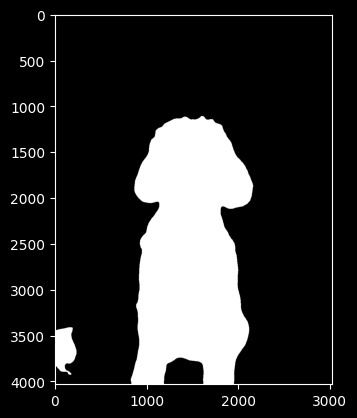

In [20]:
# PASCAL VOC class 12 = dog (하드코딩으로 안정적 선택)
target_class_id = 12

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

# Morphological 후처리: 마스크 구멍 메우기 + 경계 다듬기
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_CLOSE, kernel, iterations=3)  # 구멍 메우기
img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, kernel, iterations=1)   # 노이즈 제거

plt.imshow(img_mask, cmap='gray')
plt.show()

### Step 6: 배경 전환 (크로마키 합성)
- 마테호른 배경 이미지를 강아지 원본 크기에 맞춰 리사이즈
- `cv2.GaussianBlur()`: 마스크 경계에 블러를 적용하여 알파값 그라데이션 생성
- **알파 블렌딩**: `result = foreground × α + background × (1-α)`
  - α=1.0 (강아지 영역): 원본 그대로
  - α=0.0 (배경 영역): 마테호른 배경 사용
  - 0<α<1 (경계 영역): 자연스러운 그라데이션

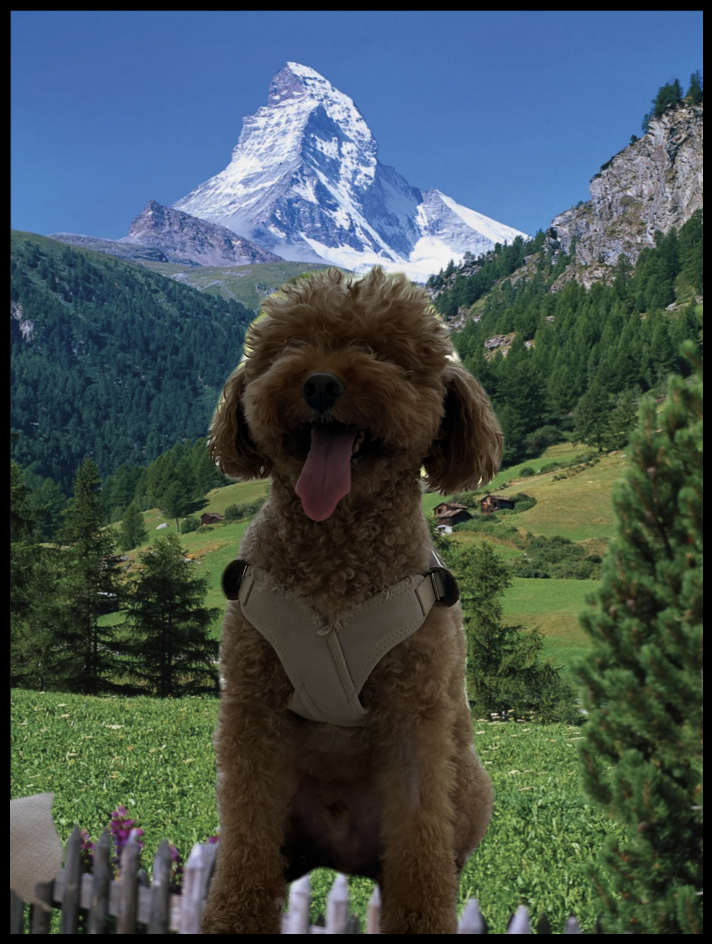

In [21]:
# 배경을 강아지 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 가우시안 블러로 마스크 경계 부드럽게 (알파 블렌딩용)
img_mask_blur = cv2.GaussianBlur(img_mask, (21, 21), 11)
alpha = img_mask_blur.astype(np.float32) / 255.0  # 0~1 범위
alpha = np.stack([alpha] * 3, axis=-1)  # 3채널 확장

# 알파 블렌딩으로 자연스러운 합성
result_img = (cat_img.astype(np.float32) * alpha + sand_img_resized.astype(np.float32) * (1 - alpha))
result_img = result_img.astype(np.uint8)

plt.figure(figsize=(10, 12))
plt.imshow(result_img)
plt.axis('off')
plt.show()

### Step 7: 아웃포커싱 효과 (보케) - 동물 사진

배경을 다른 이미지로 교체하는 크로마키 대신, 원본 배경에 가우시안 블러를 적용하여
카메라의 아웃포커싱(보케) 효과를 구현합니다.
위에서 생성한 세그멘테이션 마스크 기반 alpha를 재활용하여 강아지는 선명하게, 배경만 블러 처리합니다.

In [ ]:
# 원본 배경에 가우시안 블러 적용 (아웃포커싱/보케 효과)
img_bg_blur = cv2.GaussianBlur(cat_img, (0, 0), sigmaX=15)

# 위에서 계산한 alpha 마스크 재활용 (강아지=1.0, 배경=0.0)
# 알파 블렌딩: 강아지는 선명하게, 배경은 블러 처리
result_bokeh = (cat_img.astype(np.float32) * alpha + img_bg_blur.astype(np.float32) * (1 - alpha))
result_bokeh = result_bokeh.astype(np.uint8)

plt.figure(figsize=(10, 12))
plt.imshow(result_bokeh)
plt.axis('off')
plt.title('Out-focusing (Bokeh) - Animal Photo')
plt.show()

---
## 과제 평가 체크리스트

| # | 평가기준 | 충족 여부 | 해당 셀 |
|---|---------|:-----:|--------|
| 1 | 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다 |       | Step 5 (오류 분석 및 솔루션) |
| 2 | semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다 |       | Step 5 (4가지 솔루션 + 이유) |
| 3 | 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다 |       | Step 5 (문제점 4가지 기술) |
| 4 | 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다 |       | Step 4 예측 클래스 ID 확인 |
| 5 | 인물모드 사진을 성공적으로 제작하였다 |       | shallow_focus.ipynb (인물) |
| 6 | 아웃포커싱 효과가 적용된 인물모드 사진 1장+ |       | shallow_focus.ipynb |
| 7 | 아웃포커싱 효과가 적용된 동물 사진 1장+ |       | Step 7 (보케 효과) |
| 8 | 배경전환 크로마키 사진 1장+ |       | Step 6 (마테호른 배경 합성) |

### 주요 개선 사항 요약
1. **ImageNet 정규화** (`T.Normalize`) 적용 → 오분류 해결
2. **입력 해상도 증가** (520→1024) → 세밀한 경계 인식
3. **Morphological 후처리** (CLOSE+OPEN) → 마스크 구멍/노이즈 제거
4. **알파 블렌딩** → 자연스러운 전경/배경 합성 경계